In [1]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np
import random
from collections import deque

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size 
        self.action_size = 5 #  buy_1, sell_1,DO Nothing, buy2, sell2
        self.memory = deque(maxlen=2000)
        self.inventory1 = []
        self.inventory2 = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95 #gamma is the discount factor
        self.epsilon = 1.0 #Epsilon (ε)
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model("models/" + model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.0001))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
              
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Using TensorFlow backend.


In [2]:
import numpy as np
import random
import math, random 
import gym 
import pandas as pd

class State:
    def __init__(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        self.Stock1Price=data1[timestep] #stock 1 open price
        self.Stock2Price=data2[timestep] #stock 2 open price
        self.Stock1Blnc=Bal_stock1 #stock 1 balance
        self.Stock2Blnc=Bal_stock2 #stock 2 balance
        self.open_cash=open_cash 
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        self.portfolio_value=self.portfolio_value()

    def portfolio_value(self):
        pvalue=0
        v1=self.Stock1Price * float(self.Stock1Blnc)
        v2=self.Stock2Price * float(self.Stock2Blnc)
        v3=float(self.open_cash)
        return (v1+v2+v3)
    
    def next_opening_price(self):
        return [data1[timestep+1], data2[timestep+1]]
    
    def five_day_window(self,data, timestep):
        step = timestep
        if step < 5:
            return data[0]
        
        stock_5days = np.mean(data[step-5:step])

        return stock_5days
    
    def reset(self):
        self.Stock1Price=0 #stock 1 open price
        self.Stock2Price=0 #stock 2 open price
        self.Stock1Blnc=0 #stock 1 balance
        self.Stock2Blnc=0 #stock 2 balance
        self.open_cash=0 #cash balance
        self.fiveday_stock1=0
        self.fiveday_stock2=0
        self.portfolio_value=0
        
    def getState(self):

        res=[]
        res.append(self.Stock1Price) #stock 1 open price
        res.append(self.Stock2Price) #stock 2 open price
        res.append(self.Stock1Blnc) #stock 1 balance
        res.append(self.Stock2Blnc) #stock 2 balance
        res.append(self.open_cash) #cash balance
        res.append(self.fiveday_stock1)
        res.append(self.fiveday_stock2)        
        res.append(self.portfolio_value)


        res1=np.array([res])
        return res1

In [3]:
# In this RL trading framwork, we only use part of the data
def extract_data(date_list, stock1, stock2):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for date in date_list:
        df1 = pd.read_csv(stock1 + '/MarketData' + date + '.csv')
        df2 = pd.read_csv(stock2 + '/MarketData' + date + '.csv')
        # processing data
        df1 = df1.loc[:, ['UpdateTime','LastPrice','TotalBidVol', 'WAvgBidPri', 'TotalAskVol', 'WAvgAskPri',
                          'AskPrice1','AskVolume1', 'AskPrice2', 'AskVolume2', 'AskPrice3', 'AskVolume3',
                          'AskPrice4', 'AskVolume4', 'AskPrice5', 'AskVolume5', 'AskPrice6',
                          'AskVolume6', 'AskPrice7', 'AskVolume7', 'AskPrice8', 'AskVolume8',
                          'AskPrice9', 'AskVolume9', 'AskPrice10', 'AskVolume10', 'BidPrice1',
                          'BidVolume1', 'BidPrice2', 'BidVolume2', 'BidPrice3', 'BidVolume3',
                          'BidPrice4', 'BidVolume4', 'BidPrice5', 'BidVolume5', 'BidPrice6',
                          'BidVolume6', 'BidPrice7', 'BidVolume7', 'BidPrice8', 'BidVolume8',
                          'BidPrice9', 'BidVolume9', 'BidPrice10', 'BidVolume10', 'TradVolume']]
        df2 = df2.loc[:, ['UpdateTime','LastPrice','TotalBidVol', 'WAvgBidPri', 'TotalAskVol', 'WAvgAskPri',
                          'AskPrice1','AskVolume1', 'AskPrice2', 'AskVolume2', 'AskPrice3', 'AskVolume3',
                          'AskPrice4', 'AskVolume4', 'AskPrice5', 'AskVolume5', 'AskPrice6',
                          'AskVolume6', 'AskPrice7', 'AskVolume7', 'AskPrice8', 'AskVolume8',
                          'AskPrice9', 'AskVolume9', 'AskPrice10', 'AskVolume10', 'BidPrice1',
                          'BidVolume1', 'BidPrice2', 'BidVolume2', 'BidPrice3', 'BidVolume3',
                          'BidPrice4', 'BidVolume4', 'BidPrice5', 'BidVolume5', 'BidPrice6',
                          'BidVolume6', 'BidPrice7', 'BidVolume7', 'BidPrice8', 'BidVolume8',
                          'BidPrice9', 'BidVolume9', 'BidPrice10', 'BidVolume10', 'TradVolume']]
        hour = pd.DatetimeIndex(df1['UpdateTime']).hour
        df1['DataDate'] = None
        day_index = [0]
        df1.loc[0, 'DataDate'] = pd.Timestamp(date)
        for i in range(1, len(hour)):
            if hour[i] == 9 and hour[i-1] != 9:
                day_index.append(i)
                df1.loc[i, 'DataDate'] = df1.loc[day_index[-2], 'DataDate'] + pd.offsets.BDay()
        df1['DataDate'] = df1['DataDate'].fillna(method='ffill')

        hour = pd.DatetimeIndex(df2['UpdateTime']).hour
        df2['DataDate'] = None
        day_index = [0]
        df2.loc[0, 'DataDate'] = pd.Timestamp(date)
        for i in range(1, len(hour)):
            if hour[i] == 9 and hour[i-1] != 9:
                day_index.append(i)
                df2.loc[i, 'DataDate'] = df2.loc[day_index[-2], 'DataDate'] + pd.offsets.BDay()
        df2['DataDate'] = df2['DataDate'].fillna(method='ffill')


        # set index
        df1['DateTime'] = df1['DataDate'] + pd.to_timedelta(df1['UpdateTime'])
        df1.drop(['DataDate','UpdateTime'], axis = 1, inplace = True)
        df1.index = pd.DatetimeIndex(df1['DateTime'])
        df1.drop(['DateTime'], axis = 1, inplace = True)
        df1['TradVolume'] = df1['TradVolume'].diff()
        df1['TradVolume'][df1['TradVolume']< -1e3] = 0

        df2['DateTime'] = df2['DataDate'] + pd.to_timedelta(df2['UpdateTime'])
        df2.drop(['DataDate','UpdateTime'], axis = 1, inplace = True)
        df2.index = pd.DatetimeIndex(df2['DateTime'])
        df2.drop(['DateTime'], axis = 1, inplace = True)
        df2['TradVolume'] = df2['TradVolume'].diff()
        df2['TradVolume'][df2['TradVolume']< -1e3] = 0
        
        data1 = data1.append(df1)
        data2 = data2.append(df2)
    return data1, data2

In [37]:
import os
os.chdir('C:\\Users\\jwu21\\Documents\\Python Scripts\\HighFreq\\RL\\RL_trading')
stock1 = '600006'
stock2 = '600011'
date = ['20160509', '20160601','20160701']
df1, df2 = extract_data(date, stock1, stock2)

In [38]:
print("df1:", len(df1), " df2:", len(df2), " inner:", len(set(df1.index) & set(df2.index)))

df1: 282279  df2: 216120  inner: 154881


In [40]:
def processing_data(df1, df2):
    df1 = df1[~df1.index.duplicated()]
    df2 = df2[~df2.index.duplicated()]
    index = sorted(set(df1.index) & set(df2.index))
    return df1.loc[index, :], df2.loc[index, :]
df1, df2 = processing_data(df1, df2)

In [7]:
df1.describe()

LastPrice   TotalBidVol     WAvgBidPri   TotalAskVol  \
count  154881.000000  1.548810e+05  154881.000000  1.548810e+05   
mean        7.817499  3.953747e+06       7.575925  7.494325e+06   
std         1.100784  2.777803e+06       1.066637  3.468079e+06   
min         5.800000  2.377000e+05       5.582000  0.000000e+00   
25%         6.390000  2.722699e+06       6.224000  5.035711e+06   
50%         8.220000  3.519750e+06       7.968000  7.453351e+06   
75%         8.630000  4.650807e+06       8.431000  9.140354e+06   
max         9.820000  4.371885e+07       9.300000  2.025614e+07   

          WAvgAskPri      AskPrice1    AskVolume1      AskPrice2  \
count  154881.000000  152552.000000  1.525520e+05  152302.000000   
mean        8.090252       7.818320  6.073663e+04       7.828472   
std         1.526708       1.107479  1.081685e+05       1.108455   
min         0.000000       5.810000  1.000000e+00       5.820000   
25%         6.714000       6.390000  1.190000e+04       6.400000   
50%         8.672000       8.240000  3.320000e+04       8.250000   
75%         9.030000       8.640000  7.290000e+04       8.650000   
max        10.008000       9.820000  6.583615e+06       9.830000   

         AskVolume2      AskPrice3  ...    BidVolume6      BidPrice7  \
count  1.523020e+05  152171.000000  ...  1.548810e+05  154881.000000   
mean   8.660471e+04       7.838572  ...  1.174637e+05       7.751772   
std    1.367165e+05       1.108960  ...  1.424171e+05       1.100330   
min    3.100000e+01       5.830000  ...  1.000000e+02       5.720000   
25%    2.410000e+04       6.410000  ...  3.410000e+04       6.320000   
50%    5.300000e+04       8.260000  ...  7.500000e+04       8.150000   
75%    1.072000e+05       8.660000  ...  1.475000e+05       8.560000   
max    6.942481e+06       9.840000  ...  1.817900e+06       9.740000   

         BidVolume7      BidPrice8    BidVolume8      BidPrice9    BidVolume9  \
count  1.548810e+05  154881.000000  1.548810e+05  154881.000000  1.548810e+05   
mean   1.139992e+05       7.741711  1.087248e+05       7.731688  1.074166e+05   
std    1.386347e+05       1.100324  1.364447e+05       1.100318  1.345443e+05   
min    1.000000e+02       5.710000  1.000000e+02       5.700000  1.000000e+02   
25%    3.070000e+04       6.310000  2.850000e+04       6.300000  2.840000e+04   
50%    7.090000e+04       8.140000  6.510000e+04       8.130000  6.330000e+04   
75%    1.448870e+05       8.550000  1.374000e+05       8.540000  1.346000e+05   
max    1.521500e+06       9.730000  1.665700e+06       9.720000  1.479900e+06   

          BidPrice10   BidVolume10    TradVolume  
count  154881.000000  1.548810e+05  1.548810e+05  
mean        7.721669  1.033397e+05  1.150981e+04  
std         1.100314  1.316568e+05  4.080876e+04  
min         5.690000  1.000000e+02  0.000000e+00  
25%         6.290000  2.650000e+04  3.000000e+02  
50%         8.120000  6.050000e+04  2.200000e+03  
75%         8.530000  1.299000e+05  9.000000e+03  
max         9.710000  1.480300e+06  6.455220e+06  

[8 rows x 46 columns]

In [8]:
df2.describe()

LastPrice   TotalBidVol     WAvgBidPri   TotalAskVol  \
count  154881.000000  1.548810e+05  154881.000000  1.548810e+05   
mean        7.338452  1.890633e+06       7.173435  3.450868e+06   
std         0.199483  7.200085e+05       0.201878  1.337782e+06   
min         6.990000  3.070000e+05       6.679000  6.741850e+05   
25%         7.190000  1.406600e+06       7.030000  2.450819e+06   
50%         7.300000  1.819594e+06       7.127000  3.212142e+06   
75%         7.440000  2.217954e+06       7.238000  4.292545e+06   
max         7.870000  6.234873e+06       7.736000  7.826282e+06   

          WAvgAskPri      AskPrice1    AskVolume1      AskPrice2  \
count  154881.000000  154881.000000  1.548810e+05  154881.000000   
mean        7.622034       7.344214  7.683370e+04       7.354394   
std         0.198810       0.199605  1.276851e+05       0.199560   
min         7.251000       7.000000  1.000000e+00       7.010000   
25%         7.473000       7.200000  1.230000e+04       7.210000   
50%         7.598000       7.300000  3.940000e+04       7.310000   
75%         7.736000       7.450000  9.450000e+04       7.460000   
max         8.179000       7.870000  2.238614e+06       7.880000   

         AskVolume2      AskPrice3  ...     BidVolume6      BidPrice7  \
count  1.548810e+05  154881.000000  ...  154881.000000  154881.000000   
mean   1.296206e+05       7.364428  ...  106621.857620       7.273055   
std    1.541472e+05       0.199557  ...   93284.842565       0.199774   
min    3.300000e+01       7.020000  ...     100.000000       6.920000   
25%    3.944000e+04       7.220000  ...   46500.000000       7.120000   
50%    9.640100e+04       7.320000  ...   81500.000000       7.230000   
75%    1.689000e+05       7.470000  ...  139200.000000       7.380000   
max    2.268814e+06       7.890000  ...  998800.000000       7.800000   

         BidVolume7      BidPrice8    BidVolume8      BidPrice9    BidVolume9  \
count  1.548810e+05  154881.000000  1.548810e+05  154881.000000  1.548810e+05   
mean   9.090438e+04       7.263021  7.938250e+04       7.252973  7.276815e+04   
std    8.463051e+04       0.199793  8.033233e+04       0.199816  7.971164e+04   
min    1.000000e+02       6.910000  1.000000e+02       6.900000  1.000000e+02   
25%    3.450000e+04       7.110000  2.730000e+04       7.100000  2.290000e+04   
50%    6.770000e+04       7.220000  5.430000e+04       7.210000  4.780000e+04   
75%    1.228000e+05       7.370000  1.125000e+05       7.360000  9.720000e+04   
max    1.009500e+06       7.790000  1.009500e+06       7.780000  1.148500e+06   

          BidPrice10    BidVolume10      TradVolume  
count  154881.000000  154881.000000   154881.000000  
mean        7.242857   67529.338053     2264.116205  
std         0.199753   79700.347220    11526.614139  
min         6.890000     100.000000        0.000000  
25%         7.090000   16900.000000        0.000000  
50%         7.200000   42400.000000      100.000000  
75%         7.350000   83800.000000     1200.000000  
max         7.770000  700200.000000  1000000.000000  

[8 rows x 46 columns]

In [9]:
import matplotlib.pyplot as plt
# plot df1
fig, ax = plt.subplots(figsize= (8,4))
ax.grid()
ax2 = ax.twinx()
ax.plot(df1.LastPrice.values, 'gray')
ax2.plot(df1.TradVolume.values, 'orange')
ax.set_title(stock1 + " price and volume")

Text(0.5, 1.0, '600006 price and volume')

Text(0.5, 1.0, '600011 price and volume')

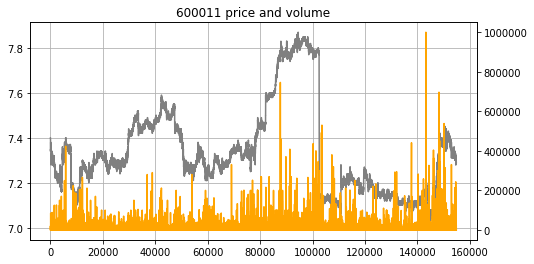

In [10]:
# plot df2
fig, ax = plt.subplots(figsize= (8,4))
ax.grid()
ax2 = ax.twinx()
ax.plot(df2.LastPrice.values, 'gray')
ax2.plot(df2.TradVolume.values, 'orange')
ax.set_title(stock2 + " price and volume")

In [41]:
# spliting data into training and testing 
# training set from 0 to 'train_len'
# test set: from days 'train_len' to day 'train_len'+ 'test_len'
def train_test_split(df1, df2, ratio = 0.8):
    train_len = round(df1.shape[0] * ratio)
    df1_train = df1.iloc[:train_len, :]
    df1_test = df1.iloc[train_len:, :]
    df2_train = df2.iloc[:train_len, :]
    df2_test = df2.iloc[train_len:, :]
    return df1_train, df1_test, df2_train, df2_test
    
df1_train, df1_test, df2_train, df2_test = train_test_split(df1, df2, ratio = 0.8)

In [12]:
#Initialize state and set benchmarking model
start_balance = 100000
total_Prof=[]
done=False

Act_datasize = len(df1_train)
batch_size = 64

#Benchmark Model

data1_train=df1_train['LastPrice']
data2_train=df2_train['LastPrice']

data1_date=df1_train.index

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_train[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_train[0]))
Act_Bench_Open_cash=start_balance/2


interval_size = 800
interval=int(Act_datasize/interval_size)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /interval_size)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /interval_size)

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range (interval,Act_datasize+1,interval):

        Price_closing_Stock1=data1_train[j-1]
        Price_closing_Stock2=data2_train[j-1]
        
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
                
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2

        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])
        


Training_Benchmark_Portfolio_Value= Total_Portfolio_value


print("Benchmark_Profit is  " + str(Training_Benchmark_Portfolio_Value) +"with Stock1:  " + str(remaining_stock1) + 
      " and stock2:  "+ str(remaining_stock2) )


Benchmark_Profit is  106790.05999999994with Stock1:  91.0 and stock2:  162.0


In [13]:
#Training run

import csv
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

episode_count = 51 

for e in range(episode_count + 1):
    print("..........")
    print("Episode " + str(e) + "/" + str(episode_count))
    
    Bal_stock1=int(np.floor((start_balance/4)/data1_train[0]))
    Bal_stock2=int(np.floor((start_balance/4)/data2_train[0]))
    open_cash=start_balance/2
    
    datasize=len(df1_train)
    done=False
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent = Agent(8)
    if e > 0:
        model_name='model_ep' + str(e-1)
        model = load_model("models/" + model_name)
        agent = Agent(8, is_eval=True, model_name=model_name)
        
    agent.inventory1 =[]
    agent.inventory2 =[]
    for i in range(Bal_stock1):
        agent.inventory1.append(data1_train[0])
    for i in range(Bal_stock2):
        agent.inventory2.append(data2_train[0]) 
    
    
    #Running episode over all days in the datasize
    for t in range(datasize):

        state_class_obj= State(data1_train, data2_train, Bal_stock1, Bal_stock2, open_cash,t)
        state_array_obj=state_class_obj.getState()
        action = agent.act(state_array_obj)
         
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100

        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:


                reward=-200000
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent.inventory1.append(data1_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                #needs to be reviewed
                
                if(state_class_obj.open_cash<500):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:  
                    reward=-change_percent_stock1*100
                

               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
                reward=-200000
                done = True
                #end episode
            else:
                bought_price1=agent.inventory1.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                if(state_class_obj.Stock1Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock1*100 #State[0] is the price of stock 1. Here we are buying 1 stock

                
        


        
        if action == 2:             # Do nothing action    
                if (abs(change_percent_stock1)<=2) and (abs(change_percent_stock2)<=2):
                    reward=10000
                elif (state_class_obj.open_cash<0.1*start_balance):
                    reward=1000000
                elif (abs(change_percent_stock1)<=2) or (abs(change_percent_stock2)<=2):
                    reward=1000
                else:
                    reward=-100000
                
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=open_cash
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                reward=-200000
                done = True
                     #end episode   
            else:
                #print("In Buy stock 2")
                agent.inventory2.append(data2_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock2Price
                
                if(state_class_obj.open_cash<5000):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=-change_percent_stock2*100
 
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    reward=-200000
                    done = True
            else:
                bought_price2=agent.inventory2.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock2Price
    
              
                if(state_class_obj.Stock2Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock2*100 
                
                
                total_profit += state_class_obj.Stock2Price - bought_price2

              
            
        
        
        if t == datasize-1:
            done=True
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        agent.memory.append((state_array_obj, action, reward, next_state_array_obj, done))
        
         
        Bal_stock1=Bal_stock1_t1
        Bal_stock2= Bal_stock2_t1
        open_cash=open_cash_t1

       
        
        if done==True:
            total_Prof.append(total_profit)
            total_stock1bal.append(len(agent.inventory1))
            total_stock2bal.append(len(agent.inventory2))
            total_open_cash.append(state_class_obj.open_cash)
            total_port_value.append(state_class_obj.portfolio_value)
            total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break
           
          

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    #if e % 10 == 0:
    agent.model.save("models/model_ep" + str(e))

..........
Episode 0/51
--------------------------------
..........
Episode 1/51
--------------------------------
..........
Episode 2/51
--------------------------------
..........
Episode 3/51
--------------------------------
..........
Episode 4/51
--------------------------------
..........
Episode 5/51
--------------------------------
..........
Episode 6/51
--------------------------------
..........
Episode 7/51
--------------------------------
..........
Episode 8/51
--------------------------------
..........
Episode 9/51
--------------------------------
..........
Episode 10/51
--------------------------------
..........
Episode 11/51
--------------------------------
..........
Episode 12/51
--------------------------------
..........
Episode 13/51
--------------------------------
..........
Episode 14/51
--------------------------------
..........
Episode 15/51
--------------------------------
..........
Episode 16/51
--------------------------------
..........
Episode 17/51

In [14]:
info = pd.DataFrame([total_stock1bal,total_stock2bal,total_open_cash,total_port_value,total_days_played]).T
info.columns = ['total_stock1bal','total_stock2bal','total_open_cash','total_port_value', 'total_days_played']
print(info)

print("Benchmark_Profit is  " + str(int(Training_Benchmark_Portfolio_Value)) +"   with remaining Stock1: " + str(remaining_stock1) + 
      "   and remaining stock2: "+ str(remaining_stock2) )

    total_stock1bal  total_stock2bal  total_open_cash  total_port_value  \
0               0.0           3381.0         74297.62          98843.68   
1               0.0           3378.0         74326.10          98647.70   
2               0.0           3378.0         74326.10          98647.70   
3               0.0           3378.0         74326.10          98647.70   
4               0.0           3378.0         74326.10          98647.70   
5               0.0           3378.0         74326.10          98647.70   
6               0.0           3378.0         74326.10          98647.70   
7               0.0           3378.0         74326.10          98647.70   
8               0.0           3378.0         74326.10          98647.70   
9               0.0           3378.0         74326.10          98647.70   
10              0.0           3378.0         74326.10          98647.70   
11              0.0           3378.0         74326.10          98647.70   
12              0.0      

In [15]:
## testing
# calculate benchmark profit based on test set
total_Prof=[]
done=False

Act_datasize = len(df1_test)
batch_size = 64
start_balance = 100000
#Benchmark Model
# Take last price in a new variable
data1_test=df1_test['LastPrice']
data2_test=df2_test['LastPrice']

data1_date=df1_test.index


Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2

#sell 10% of stock in 10 intervals
interval_num = 800
interval=int(Act_datasize/interval_num)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /interval_num)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /interval_num)


remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range(interval,Act_datasize,interval):

        Price_closing_Stock1=data1_test[j-1]
        Price_closing_Stock2=data2_test[j-1]
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')

        
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2
        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value 
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])


Test_Benchmark_Portfolio_Value= Total_Portfolio_value


print("Benchmark_Profit is: " + str(Test_Benchmark_Portfolio_Value) +"  with remaining Stock1: " + str(remaining_stock1) + 
      "   and remaining stock2 at the end: "+ str(remaining_stock2) )

Benchmark_Profit is: 98595.11000000007  with remaining Stock1: 458.0   and remaining stock2 at the end: 241.0


Text(0.5, 1.0, 'Benchmark_Port_Value')

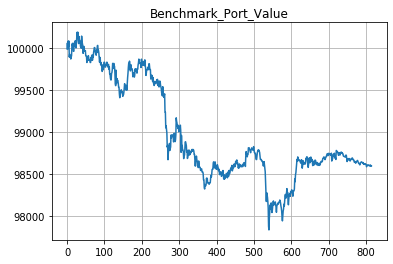

In [16]:
plt.plot(pd.DataFrame.from_records(Benchmark_Port_Value).iloc[:,1])
plt.grid()
plt.title('Benchmark_Port_Value')

In [17]:
#Actual run to compare with the test results 

import csv
episode_count=0

#Define arrays to store per episode values 
Act_total_Prof=[]
Act_total_stock1bal=[]
Act_total_stock2bal=[]
Act_total_open_cash=[]
Act_total_port_value=[]
Act_total_days_played=[]
actions_done_perday=[]
portfolio_value=[]

from keras.models import load_model

model_name='model_ep50'
model = load_model("models/" + model_name)

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2

for e in range(1): #here we run only for 1 episode, as it is Test run

    Bal_stock1_t2=Act_Bench_Stock1_Bal
    Bal_stock2_t2=Act_Bench_Stock2_Bal
    done=False
    open_cash_t2= Act_Bench_Open_cash  
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent_test = Agent(8, is_eval=True, model_name=model_name)

    agent_test.inventory1 =[]
    agent_test.inventory2 =[]
    for i in range(Bal_stock1_t2):
        agent_test.inventory1.append(data1_test[0])
    for i in range(Bal_stock2_t2):
        agent_test.inventory2.append(data2_test[0]) 
    
    
    timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(Act_datasize):
        print("..........")
        
        print(df1_test.index[t])
        state_class_obj= State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
        state_array_obj=state_class_obj.getState()
        action = agent_test.act(state_array_obj)
        
        print("Total portfolio value: " + str(state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash: "+str(state_class_obj.open_cash))


        
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        print("change_percent_stock1:  "+str(change_percent_stock1))
        print("change_percent_stock2:  "+str(change_percent_stock2))
        
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:

                done = True
                     
            else:
                agent_test.inventory1.append(data1_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                
               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :

                done = True
                #end episode
            else:
                #print("In sell stock 1")
                bought_price2=agent_test.inventory1.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                 
        


        
        if action == 2:             # Do nothing action    
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:


                done = True
                #end episode   
            else:
                #print("In Buy stock 2")
                agent_test.inventory2.append(data2_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock2Price
                
              
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    
                done = True
                #end episode
            else:

                bought_price2=agent_test.inventory2.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock2Price
    

               

        if t == Act_datasize-1:
            print("t==datasize")
            done=True
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            print("t!=datasize "+str(open_cash_t2))
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        print("Action is "+str(action)+" reward is " + str(reward))


       
        
        actions_done_perday.append(action)
        portfolio_value.append(next_state_class_obj.portfolio_value)

        if done==True:
            print("--------------------------------")
            print("Total Profit: " + str(total_profit))
            print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(Act_datasize))
            print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            Act_total_Prof.append(total_profit)
            Act_total_stock1bal.append(len(agent_test.inventory1))
            Act_total_stock2bal.append(len(agent_test.inventory2))
            Act_total_open_cash.append(state_class_obj.open_cash)
            Act_total_port_value.append(state_class_obj.portfolio_value)
            Act_total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break

..........
2016-07-19 13:50:25
Total portfolio value: 99991.97  stock 1 number: 2903  stock 2 number: 3501  open cash: 50000.0
change_percent_stock1:  0.0
change_percent_stock2:  0.0
t!=datasize 50008.61
Action is 1 reward is 0
..........
2016-07-19 13:50:28
Total portfolio value: 100026.98  stock 1 number: 2902  stock 2 number: 3501  open cash: 50008.61
change_percent_stock1:  0.0
change_percent_stock2:  0.14005602240897305
t!=datasize 50017.22
Action is 1 reward is 0
..........
2016-07-19 13:50:31
Total portfolio value: 100085.0  stock 1 number: 2901  stock 2 number: 3501  open cash: 50017.22
change_percent_stock1:  0.23228803716610164
change_percent_stock2:  0.14005602240897305
t!=datasize 50025.85
Action is 1 reward is 0
..........
2016-07-19 13:50:34
Total portfolio value: 100085.0  stock 1 number: 2900  stock 2 number: 3501  open cash: 50025.85
change_percent_stock1:  0.23228803716610164
change_percent_stock2:  0.14005602240897305
t!=datasize 50034.479999999996
Action is 1 reward

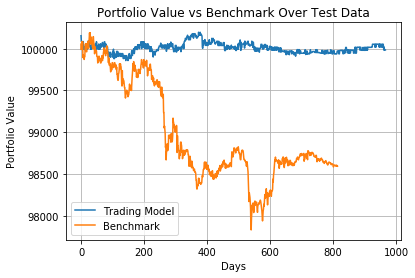

In [18]:
# Test Stock Prices and actions taken by agent Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

pd_bm=pd.DataFrame.from_records(Benchmark_Port_Value)
pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

x1 = np.array(df1_test.index)
y1 = portfolio_value

x2=pd_bm[0]
y2=pd_bm[1]


plt.title("Portfolio Value vs Benchmark Over Test Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")

interval_size = 800
interval = int(len(y1)/interval_size)
plt.plot(np.array(y1)[list(range(interval, len(y1), interval))])
plt.plot(y2)


plt.legend(('Trading Model', 'Benchmark'))
plt.grid()
plt.show()

In [19]:
# increase Training run to 100 episodes

import csv
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

episode_count = 101

for e in range(episode_count + 1):
    print("..........")
    print("Episode " + str(e) + "/" + str(episode_count))
    
    Bal_stock1=int(np.floor((start_balance/4)/data1_train[0]))
    Bal_stock2=int(np.floor((start_balance/4)/data2_train[0]))
    open_cash=start_balance/2
    
    datasize=len(df1_train)
    done=False
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent = Agent(8)
    if e > 0:
        model_name='model_ep' + str(e-1)
        model = load_model("models/" + model_name)
        agent = Agent(8, is_eval=True, model_name=model_name)
        
    agent.inventory1 =[]
    agent.inventory2 =[]
    for i in range(Bal_stock1):
        agent.inventory1.append(data1_train[0])
    for i in range(Bal_stock2):
        agent.inventory2.append(data2_train[0]) 
    
    
    #Running episode over all days in the datasize
    for t in range(datasize):

        state_class_obj= State(data1_train, data2_train, Bal_stock1, Bal_stock2, open_cash,t)
        state_array_obj=state_class_obj.getState()
        action = agent.act(state_array_obj)
         
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100

        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:


                reward=-200000
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent.inventory1.append(data1_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                #needs to be reviewed
                
                if(state_class_obj.open_cash<500):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:  
                    reward=-change_percent_stock1*100
                

               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
                reward=-200000
                done = True
                #end episode
            else:
                bought_price1=agent.inventory1.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                if(state_class_obj.Stock1Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock1*100 #State[0] is the price of stock 1. Here we are buying 1 stock

                
        


        
        if action == 2:             # Do nothing action    
                if (abs(change_percent_stock1)<=2) and (abs(change_percent_stock2)<=2):
                    reward=10000
                elif (state_class_obj.open_cash<0.1*start_balance):
                    reward=1000000
                elif (abs(change_percent_stock1)<=2) or (abs(change_percent_stock2)<=2):
                    reward=1000
                else:
                    reward=-100000
                
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=open_cash
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                reward=-200000
                done = True
                     #end episode   
            else:
                #print("In Buy stock 2")
                agent.inventory2.append(data2_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock2Price
                
                if(state_class_obj.open_cash<5000):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=-change_percent_stock2*100
 
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    reward=-200000
                    done = True
            else:
                bought_price2=agent.inventory2.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock2Price
    
              
                if(state_class_obj.Stock2Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock2*100 
                
                
                total_profit += state_class_obj.Stock2Price - bought_price2

              
            
        
        
        if t == datasize-1:
            done=True
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        agent.memory.append((state_array_obj, action, reward, next_state_array_obj, done))
        
         
        Bal_stock1=Bal_stock1_t1
        Bal_stock2= Bal_stock2_t1
        open_cash=open_cash_t1

       
        
        if done==True:
            total_Prof.append(total_profit)
            total_stock1bal.append(len(agent.inventory1))
            total_stock2bal.append(len(agent.inventory2))
            total_open_cash.append(state_class_obj.open_cash)
            total_port_value.append(state_class_obj.portfolio_value)
            total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break
           
          

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    #if e % 10 == 0:
    agent.model.save("models/model_ep" + str(e))

..........
Episode 0/101
--------------------------------
..........
Episode 1/101
--------------------------------
..........
Episode 2/101
--------------------------------
..........
Episode 3/101
--------------------------------
..........
Episode 4/101
--------------------------------
..........
Episode 5/101
--------------------------------
..........
Episode 6/101
--------------------------------
..........
Episode 7/101
--------------------------------
..........
Episode 8/101
--------------------------------
..........
Episode 9/101
--------------------------------
..........
Episode 10/101
--------------------------------
..........
Episode 11/101
--------------------------------
..........
Episode 12/101
--------------------------------
..........
Episode 13/101
--------------------------------
..........
Episode 14/101
--------------------------------
..........
Episode 15/101
--------------------------------
..........
Episode 16/101
--------------------------------
.......

In [20]:
info = pd.DataFrame([total_stock1bal,total_stock2bal,total_open_cash,total_port_value,total_days_played]).T
info.columns = ['total_stock1bal','total_stock2bal','total_open_cash','total_port_value', 'total_days_played']
print(info)

print("Benchmark_Profit is  " + str(int(Training_Benchmark_Portfolio_Value)) +"   with remaining Stock1: " + str(remaining_stock1) + 
      "   and remaining stock2: "+ str(remaining_stock2) )

     total_stock1bal  total_stock2bal  total_open_cash  total_port_value  \
0             4105.0              0.0         74549.75          99097.65   
1             4111.0              0.0         74545.57          98471.59   
2             4111.0              0.0         74545.57          98471.59   
3             4111.0              0.0         74545.57          98471.59   
4             4111.0              0.0         74545.57          98471.59   
..               ...              ...              ...               ...   
97            4111.0              0.0         74545.57          98471.59   
98            4111.0              0.0         74545.57          98471.59   
99            4111.0              0.0         74545.57          98471.59   
100           4111.0              0.0         74545.57          98471.59   
101           4111.0              0.0         74545.57          98471.59   

     total_days_played  
0               3680.0  
1               3378.0  
2           

In [42]:
## testing
# calculate benchmark profit based on test set
total_Prof=[]
done=False

Act_datasize = len(df1_test)
batch_size = 64
start_balance = 100000
#Benchmark Model
# Take last price in a new variable
data1_test=df1_test['LastPrice']
data2_test=df2_test['LastPrice']

data1_date=df1_test.index


Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2

#sell 10% of stock in 10 intervals
interval_num = 800
interval=int(Act_datasize/interval_num)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /interval_num)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /interval_num)


remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range(interval,Act_datasize,interval):

        Price_closing_Stock1=data1_test[j-1]
        Price_closing_Stock2=data2_test[j-1]
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')

        
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2
        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value 
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])


Test_Benchmark_Portfolio_Value= Total_Portfolio_value


print("Benchmark_Profit is: " + str(Test_Benchmark_Portfolio_Value) +"  with remaining Stock1: " + str(remaining_stock1) + 
      "   and remaining stock2 at the end: "+ str(remaining_stock2) )

Benchmark_Profit is: 98595.11000000007  with remaining Stock1: 458.0   and remaining stock2 at the end: 241.0


In [45]:
#Actual run to compare with the test results 

import csv
episode_count=0

#Define arrays to store per episode values 
Act_total_Prof=[]
Act_total_stock1bal=[]
Act_total_stock2bal=[]
Act_total_open_cash=[]
Act_total_port_value=[]
Act_total_days_played=[]
actions_done_perday=[]
portfolio_value=[]

from keras.models import load_model

model_name='model_ep100'
model = load_model("models/" + model_name)

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2

for e in range(1): #here we run only for 1 episode, as it is Test run

    Bal_stock1_t2=Act_Bench_Stock1_Bal
    Bal_stock2_t2=Act_Bench_Stock2_Bal
    done=False
    open_cash_t2= Act_Bench_Open_cash  
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent_test = Agent(8, is_eval=True, model_name=model_name)

    agent_test.inventory1 =[]
    agent_test.inventory2 =[]
    for i in range(Bal_stock1_t2):
        agent_test.inventory1.append(data1_test[0])
    for i in range(Bal_stock2_t2):
        agent_test.inventory2.append(data2_test[0]) 
    
    
    timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(Act_datasize):
        print("..........")
        
        print(df1_test.index[t])
        state_class_obj= State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
        state_array_obj=state_class_obj.getState()
        action = agent_test.act(state_array_obj)
        
        print("Total portfolio value: " + str(state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash: "+str(state_class_obj.open_cash))


        
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        print("change_percent_stock1:  "+str(change_percent_stock1))
        print("change_percent_stock2:  "+str(change_percent_stock2))
        
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:

                done = True
                     
            else:
                agent_test.inventory1.append(data1_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                
               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :

                done = True
                #end episode
            else:
                #print("In sell stock 1")
                bought_price2=agent_test.inventory1.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                 
        


        
        if action == 2:             # Do nothing action    
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:


                done = True
                #end episode   
            else:
                #print("In Buy stock 2")
                agent_test.inventory2.append(data2_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock2Price
                
              
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    
                done = True
                #end episode
            else:

                bought_price2=agent_test.inventory2.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock2Price
    

               

        if t == Act_datasize-1:
            print("t==datasize")
            done=True
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            print("t!=datasize "+str(open_cash_t2))
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        print("Action is "+str(action)+" reward is " + str(reward))


       
        
        actions_done_perday.append(action)
        portfolio_value.append(next_state_class_obj.portfolio_value)

        if done==True:
            print("--------------------------------")
            print("Total Profit: " + str(total_profit))
            print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(Act_datasize))
            print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            Act_total_Prof.append(total_profit)
            Act_total_stock1bal.append(len(agent_test.inventory1))
            Act_total_stock2bal.append(len(agent_test.inventory2))
            Act_total_open_cash.append(state_class_obj.open_cash)
            Act_total_port_value.append(state_class_obj.portfolio_value)
            Act_total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break

..........
2016-07-19 13:50:25
Total portfolio value: 99991.97  stock 1 number: 2903  stock 2 number: 3501  open cash: 50000.0
change_percent_stock1:  0.0
change_percent_stock2:  0.0
t!=datasize 50007.14
Action is 4 reward is 0
..........
2016-07-19 13:50:28
Total portfolio value: 100026.97  stock 1 number: 2903  stock 2 number: 3500  open cash: 50007.14
change_percent_stock1:  0.0
change_percent_stock2:  0.14005602240897305
t!=datasize 50014.29
Action is 4 reward is 0
..........
2016-07-19 13:50:31
Total portfolio value: 100085.03  stock 1 number: 2903  stock 2 number: 3499  open cash: 50014.29
change_percent_stock1:  0.23228803716610164
change_percent_stock2:  0.14005602240897305
t!=datasize 50021.44
Action is 4 reward is 0
..........
2016-07-19 13:50:34
Total portfolio value: 100085.03  stock 1 number: 2903  stock 2 number: 3498  open cash: 50021.44
change_percent_stock1:  0.23228803716610164
change_percent_stock2:  0.14005602240897305
t!=datasize 50028.590000000004
Action is 4 rewa

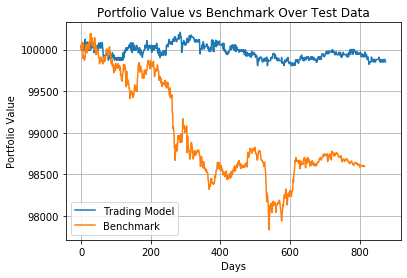

In [46]:
# Test Stock Prices and actions taken by agent Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

pd_bm=pd.DataFrame.from_records(Benchmark_Port_Value)
pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

x1 = np.array(df1_test.index)
y1 = portfolio_value

x2=pd_bm[0]
y2=pd_bm[1]


plt.title("Portfolio Value vs Benchmark Over Test Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")

interval_size = len(y2)
interval = int(len(y1)/interval_size)
plt.plot(np.array(y1)[list(range(interval, len(y1), interval))])
plt.plot(y2)

plt.legend(('Trading Model', 'Benchmark'))
plt.grid()
plt.show()

In [ ]:
# using all data from May 09 to Dec 31
stock1 = '600006'
stock2 = '600011'
date = ['20160509', '20160601','20160701','20160801','20160901','20161001','20161101','20161201']
df1, df2 = extract_data(date, stock1, stock2)

In [ ]:
print("df1:", len(df1), " df2:", len(df2), " inner:", len(set(df1.index) & set(df2.index)))

In [ ]:
df1, df2 = processing_data(df1, df2)
df1_train, df1_test, df2_train, df2_test = train_test_split(df1, df2, ratio = 0.8)

In [ ]:
#Initialize state and set benchmarking model
start_balance = 100000
total_Prof=[]
done=False

Act_datasize = len(df1_train)
batch_size = 64

#Benchmark Model

data1_train=df1_train['LastPrice']
data2_train=df2_train['LastPrice']

data1_date=df1_train.index

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_train[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_train[0]))
Act_Bench_Open_cash=start_balance/2


interval_size = 2000 # increase frequency
interval=int(Act_datasize/interval_size)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /interval_size)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /interval_size)

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range (interval,Act_datasize+1,interval):

        Price_closing_Stock1=data1_train[j-1]
        Price_closing_Stock2=data2_train[j-1]
        
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
                
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2

        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])
        


Training_Benchmark_Portfolio_Value= Total_Portfolio_value


print("Benchmark_Profit is  " + str(Training_Benchmark_Portfolio_Value) +"with Stock1:  " + str(remaining_stock1) + 
      " and stock2:  "+ str(remaining_stock2) )


In [28]:
#Training run

import csv
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

episode_count = 51 

for e in range(episode_count + 1):
    print("..........")
    print("Episode " + str(e) + "/" + str(episode_count))
    
    Bal_stock1=int(np.floor((start_balance/4)/data1_train[0]))
    Bal_stock2=int(np.floor((start_balance/4)/data2_train[0]))
    open_cash=start_balance/2
    
    datasize=len(df1_train)
    done=False
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent = Agent(8)
    if e > 0:
        model_name='model_ep' + str(e-1)
        model = load_model("models/" + model_name)
        agent = Agent(8, is_eval=True, model_name=model_name)
        
    agent.inventory1 =[]
    agent.inventory2 =[]
    for i in range(Bal_stock1):
        agent.inventory1.append(data1_train[0])
    for i in range(Bal_stock2):
        agent.inventory2.append(data2_train[0]) 
    
    
    #Running episode over all days in the datasize
    for t in range(datasize):

        state_class_obj= State(data1_train, data2_train, Bal_stock1, Bal_stock2, open_cash,t)
        state_array_obj=state_class_obj.getState()
        action = agent.act(state_array_obj)
         
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100

        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:


                reward=-200000
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent.inventory1.append(data1_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                #needs to be reviewed
                
                if(state_class_obj.open_cash<500):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:  
                    reward=-change_percent_stock1*100
                

               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
                reward=-200000
                done = True
                #end episode
            else:
                bought_price1=agent.inventory1.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                if(state_class_obj.Stock1Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock1*100 #State[0] is the price of stock 1. Here we are buying 1 stock

                
        


        
        if action == 2:             # Do nothing action    
                if (abs(change_percent_stock1)<=2) and (abs(change_percent_stock2)<=2):
                    reward=10000
                elif (state_class_obj.open_cash<0.1*start_balance):
                    reward=1000000
                elif (abs(change_percent_stock1)<=2) or (abs(change_percent_stock2)<=2):
                    reward=1000
                else:
                    reward=-100000
                
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=open_cash
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                reward=-200000
                done = True
                     #end episode   
            else:
                #print("In Buy stock 2")
                agent.inventory2.append(data2_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock2Price
                
                if(state_class_obj.open_cash<5000):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=-change_percent_stock2*100
 
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    reward=-200000
                    done = True
            else:
                bought_price2=agent.inventory2.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock2Price
    
              
                if(state_class_obj.Stock2Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock2*100 
                
                
                total_profit += state_class_obj.Stock2Price - bought_price2

              
            
        
        
        if t == datasize-1:
            done=True
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        agent.memory.append((state_array_obj, action, reward, next_state_array_obj, done))
        
         
        Bal_stock1=Bal_stock1_t1
        Bal_stock2= Bal_stock2_t1
        open_cash=open_cash_t1

       
        
        if done==True:
            total_Prof.append(total_profit)
            total_stock1bal.append(len(agent.inventory1))
            total_stock2bal.append(len(agent.inventory2))
            total_open_cash.append(state_class_obj.open_cash)
            total_port_value.append(state_class_obj.portfolio_value)
            total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break
           
          

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    #if e % 10 == 0:
    agent.model.save("models/model_ep" + str(e))

--------------------------------
..........
Episode 2/51
--------------------------------
..........
Episode 3/51
--------------------------------
..........
Episode 4/51
--------------------------------
..........
Episode 5/51
--------------------------------
..........
Episode 6/51
--------------------------------
..........
Episode 7/51
--------------------------------
..........
Episode 8/51
--------------------------------
..........
Episode 9/51
--------------------------------
..........
Episode 10/51
--------------------------------
..........
Episode 11/51
--------------------------------
..........
Episode 12/51
--------------------------------
..........
Episode 13/51
--------------------------------
..........
Episode 14/51
--------------------------------
..........
Episode 15/51
--------------------------------
..........
Episode 16/51
--------------------------------
..........
Episode 17/51
--------------------------------
..........
Episode 18/51
----------------------

In [29]:
info = pd.DataFrame([total_stock1bal,total_stock2bal,total_open_cash,total_port_value,total_days_played]).T
info.columns = ['total_stock1bal','total_stock2bal','total_open_cash','total_port_value', 'total_days_played']
print(info)

print("Benchmark_Profit is  " + str(int(Training_Benchmark_Portfolio_Value)) +"   with remaining Stock1: " + str(remaining_stock1) + 
      "   and remaining stock2: "+ str(remaining_stock2) )

    total_stock1bal  total_stock2bal  total_open_cash  total_port_value  \
0           11481.0           4138.0             2.13         100247.69   
1           11484.0           4142.0             5.10         100412.68   
2           11484.0           4142.0             5.10         100412.68   
3           11484.0           4142.0             5.10         100412.68   
4           11484.0           4142.0             5.10         100412.68   
5           11484.0           4142.0             5.10         100412.68   
6           11484.0           4142.0             5.10         100412.68   
7           11484.0           4142.0             5.10         100412.68   
8           11484.0           4142.0             5.10         100412.68   
9           11484.0           4142.0             5.10         100412.68   
10          11484.0           4142.0             5.10         100412.68   
11          11484.0           4142.0             5.10         100412.68   
12          11484.0      

In [30]:
## testing
# calculate benchmark profit based on test set
total_Prof=[]
done=False

Act_datasize = len(df1_test)
batch_size = 64
start_balance = 100000
#Benchmark Model
# Take last price in a new variable
data1_test=df1_test['LastPrice']
data2_test=df2_test['LastPrice']

data1_date=df1_test.index


Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2

#sell 10% of stock in 10 intervals
interval_num = 2000
interval=int(Act_datasize/interval_num)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /interval_num)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /interval_num)


remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range(interval,Act_datasize,interval):

        Price_closing_Stock1=data1_test[j-1]
        Price_closing_Stock2=data2_test[j-1]
        date_stock1=data1_date[j-1].strftime('%Y-%m-%d')

        
        stocks1Value= Act_stocks1 * Price_closing_Stock1
        stocks2Value= Act_stocks2 * Price_closing_Stock2
        remaining_stock1=remaining_stock1-Act_stocks1
        remaining_stock2=remaining_stock2-Act_stocks2
        
        
        
        Stock1_Port_value=remaining_stock1*Price_closing_Stock1
        Stock2_Port_value=remaining_stock2*Price_closing_Stock2
        Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value 
        
        Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
        Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])


Test_Benchmark_Portfolio_Value= Total_Portfolio_value


print("Benchmark_Profit is: " + str(Test_Benchmark_Portfolio_Value) +"  with remaining Stock1: " + str(remaining_stock1) + 
      "   and remaining stock2 at the end: "+ str(remaining_stock2) )

Benchmark_Profit is: 98599.61000000009  with remaining Stock1: 1300.0   and remaining stock2 at the end: 1461.0


In [31]:
#Actual run to compare with the test results 

import csv
episode_count=0

#Define arrays to store per episode values 
Act_total_Prof=[]
Act_total_stock1bal=[]
Act_total_stock2bal=[]
Act_total_open_cash=[]
Act_total_port_value=[]
Act_total_days_played=[]
actions_done_perday=[]
portfolio_value=[]

from keras.models import load_model

model_name='model_ep50'
model = load_model("models/" + model_name)

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2

for e in range(1): #here we run only for 1 episode, as it is Test run

    Bal_stock1_t2=Act_Bench_Stock1_Bal
    Bal_stock2_t2=Act_Bench_Stock2_Bal
    done=False
    open_cash_t2= Act_Bench_Open_cash  
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent_test = Agent(8, is_eval=True, model_name=model_name)

    agent_test.inventory1 =[]
    agent_test.inventory2 =[]
    for i in range(Bal_stock1_t2):
        agent_test.inventory1.append(data1_test[0])
    for i in range(Bal_stock2_t2):
        agent_test.inventory2.append(data2_test[0]) 
    
    
    timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(Act_datasize):
        print("..........")
        
        print(df1_test.index[t])
        state_class_obj= State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
        state_array_obj=state_class_obj.getState()
        action = agent_test.act(state_array_obj)
        
        print("Total portfolio value: " + str(state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash: "+str(state_class_obj.open_cash))


        
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        print("change_percent_stock1:  "+str(change_percent_stock1))
        print("change_percent_stock2:  "+str(change_percent_stock2))
        
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:

                done = True
                     
            else:
                agent_test.inventory1.append(data1_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                
               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :

                done = True
                #end episode
            else:
                #print("In sell stock 1")
                bought_price2=agent_test.inventory1.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                 
        


        
        if action == 2:             # Do nothing action    
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:


                done = True
                #end episode   
            else:
                #print("In Buy stock 2")
                agent_test.inventory2.append(data2_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock2Price
                
              
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    
                done = True
                #end episode
            else:

                bought_price2=agent_test.inventory2.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock2Price
    

               

        if t == Act_datasize-1:
            print("t==datasize")
            done=True
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            print("t!=datasize "+str(open_cash_t2))
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        print("Action is "+str(action)+" reward is " + str(reward))


       
        
        actions_done_perday.append(action)
        portfolio_value.append(next_state_class_obj.portfolio_value)

        if done==True:
            print("--------------------------------")
            print("Total Profit: " + str(total_profit))
            print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(Act_datasize))
            print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            Act_total_Prof.append(total_profit)
            Act_total_stock1bal.append(len(agent_test.inventory1))
            Act_total_stock2bal.append(len(agent_test.inventory2))
            Act_total_open_cash.append(state_class_obj.open_cash)
            Act_total_port_value.append(state_class_obj.portfolio_value)
            Act_total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break

..........
2016-11-17 11:02:36
Total portfolio value: 99993.18  stock 1 number: 3320  stock 2 number: 3481  open cash: 50000.0
change_percent_stock1:  0.0
change_percent_stock2:  0.0
t!=datasize 49992.82
Action is 3 reward is 0
..........
2016-11-17 11:02:39
Total portfolio value: 99959.98  stock 1 number: 3320  stock 2 number: 3482  open cash: 49992.82
change_percent_stock1:  -0.1328021248340063
change_percent_stock2:  0.0
t!=datasize 49985.64
Action is 3 reward is 0
..........
2016-11-17 11:02:45
Total portfolio value: 99959.98  stock 1 number: 3320  stock 2 number: 3483  open cash: 49985.64
change_percent_stock1:  -0.1328021248340063
change_percent_stock2:  0.0
t!=datasize 49978.46
Action is 3 reward is 0
..........
2016-11-17 11:02:51
Total portfolio value: 99925.13999999998  stock 1 number: 3320  stock 2 number: 3484  open cash: 49978.46
change_percent_stock1:  -0.1328021248340063
change_percent_stock2:  -0.13927576601671013
t!=datasize 49971.29
Action is 3 reward is 0
..........


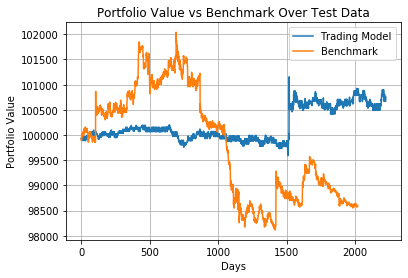

In [32]:
# Test Stock Prices and actions taken by agent Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

pd_bm=pd.DataFrame.from_records(Benchmark_Port_Value)
pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

x1 = np.array(df1_test.index)
y1 = portfolio_value

x2=pd_bm[0]
y2=pd_bm[1]


plt.title("Portfolio Value vs Benchmark Over Test Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")

interval_size = 2000
interval = int(len(y1)/interval_size)
plt.plot(np.array(y1)[list(range(interval, len(y1), interval))])
plt.plot(y2)

plt.legend(('Trading Model', 'Benchmark'))
plt.grid()
plt.show()